### Setup básico
Importamos as bibliotecas permitidas:
- **NumPy e Pandas**: manipulação de dados.
- **Matplotlib e Seaborn**: visualizações.
- **Scikit-Learn**: pré-processamento, modelagem, métricas e otimização.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression


### Carregar os dados
- Definimos `train.csv` como conjunto de treino e `test.csv` como conjunto de teste.
- Definimos `labels` como variável alvo e `id` como identificador.


In [24]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

TARGET = "labels"
ID_COL = "id"

### Feature Engineering
Criamos novas variáveis que podem melhorar o poder preditivo:
- `funding_log`: transformação logarítmica para reduzir assimetria.
- `funding_per_round`: investimento médio por rodada.
- `milestone_span` e `milestones_per_year`: medidas de intensidade temporal.
- `funding_bin`: categorização em faixas (quantis).
- `funding_per_round_times_milestone`: interação entre investimento e tempo.


In [25]:
def feature_engineering(df):
    df = df.copy()
    
    if 'funding_total_usd' in df.columns and 'funding_rounds' in df.columns:
        df['funding_log'] = np.log1p(df['funding_total_usd'])
        df['funding_per_round'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)
        
    if 'milestones' in df.columns and 'age_first_milestone_year' in df.columns and 'age_last_milestone_year' in df.columns:
        df['milestone_span'] = df['age_last_milestone_year'] - df['age_first_milestone_year']
        df['milestones_per_year'] = df['milestones'] / (df['milestone_span'].replace(0, np.nan).fillna(1))
    
    if 'funding_per_round' in df.columns and 'milestone_span' in df.columns:
        df['funding_per_round_times_milestone'] = df['funding_per_round'] * df['milestone_span']
    
    # Substituir valores infinitos e preencher nulos
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))
    
    return df

train = feature_engineering(train)
test = feature_engineering(test)


### Separação de variáveis
- Definimos `X` (features) e `y` (alvo).
- Identificamos variáveis numéricas e categóricas.


In [26]:
X = train.drop([ID_COL, TARGET], axis=1)
y = train[TARGET]
X_test = test.drop(ID_COL, axis=1)

### Pré-processamento
- Variáveis numéricas → imputação (mediana) + padronização.
- Variáveis categóricas → imputação (moda) + OneHotEncoder.
- Variável ordinal `funding_bin` → OrdinalEncoder.


In [27]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
])

### Divisão em treino e validação
- Usamos **70% treino / 30% validação**.
- Estratificação garante proporções iguais da variável alvo.


In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### Modelo RandomForest com Otimização
- Usamos `RandomForestClassifier` com `class_weight="balanced"`.
- Ajustamos hiperparâmetros com `RandomizedSearchCV` (busca aleatória).
- Métrica de avaliação: **Acurácia**.


In [29]:
rf = RandomForestClassifier(
    n_estimators=800, max_depth=30, min_samples_split=2,
    min_samples_leaf=1, max_features="sqrt", random_state=42,
    class_weight="balanced"
)

gb = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
)

lr = LogisticRegression(max_iter=500, class_weight="balanced")

voting_clf = VotingClassifier(
    estimators=[("rf", rf), ("gb", gb), ("lr", lr)],
    voting="soft", n_jobs=-1
)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", voting_clf)])
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Avaliação na validação
- Calculamos **acurácia, precisão, recall e F1**.
- Exibimos a **matriz de confusão** para entender erros de classificação.


Acurácia: 0.8092783505154639
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        68
           1       0.81      0.92      0.86       126

    accuracy                           0.81       194
   macro avg       0.81      0.76      0.78       194
weighted avg       0.81      0.81      0.80       194



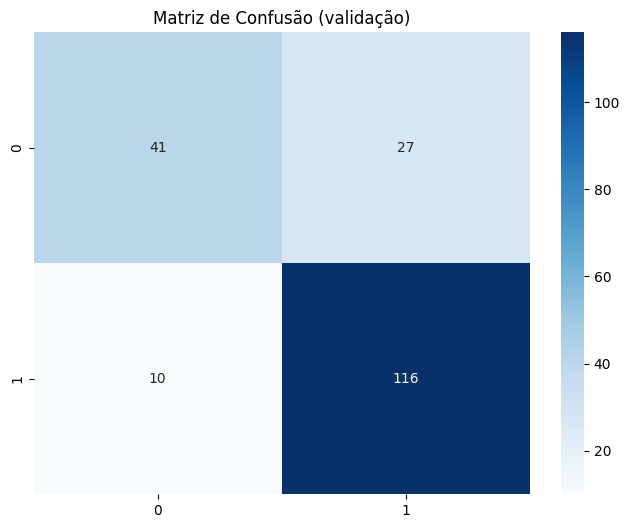

In [30]:
y_val_pred = pipe.predict(X_val)

print("Acurácia:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (validação)")
plt.show()

### Treino final e submissão
- Re-treinamos o modelo com **todos os dados de treino**.
- Geramos o arquivo `submission.csv` para envio.


In [32]:
pipe.fit(X, y)
y_test_pred = pipe.predict(X_test)

submission = pd.DataFrame({ID_COL: test[ID_COL], TARGET: y_test_pred})
submission.to_csv("submission.csv", index=False)
print("Arquivo submission.csv gerado!")
print("Arquivo submission.csv gerado e pronto uso!")

Arquivo submission.csv gerado!
Arquivo submission.csv gerado e pronto uso!


### Salvar modelo treinado
Salvamos o modelo em `randomforest_best.pkl` usando `pickle`.


In [34]:
with open("randomforest_best.pkl", "wb") as f:
    pickle.dump(pipe, f)